## Artificial Intelligence for Cybersecurity Project
### Dataset used: [Malicious URLs dataset by Manu Siddhartha](https://www.kaggle.com/datasets/sid321axn/malicious-urls-dataset)

### Candidates: Riccardo Fantasia & Leonardo Pantani

In [1]:
# removing warnings from prints
import warnings
warnings.filterwarnings("ignore")

In [2]:
# importing raw dataset
import pandas as pd
df_raw = pd.read_csv("UNIPI-IA-dataset.csv")

In [3]:
# we define the types in a specific order. This is because in case of duplicates, for example:
# https://www.strange-site.com/youwonaprize- malware
# https://www.strange-site.com/youwonaprize - benign
#
# we would remove all samples, except the first one. This was decided because, in this context,
# it is preferable to have a False Positive (FP), manually "correctable" by the user, than a False Negative (FN),
# which could expose the user to a malicious site.

types = ["malware", "phishing", "defacement", "benign"]

df_raw["type"] = pd.Categorical(df_raw["type"], categories=types, ordered=True)
df = df_raw.sort_values(by="type").drop_duplicates(subset="url", keep="first")

print(f"Samples in original dataset: {df_raw.shape[0]}\nSamples in no-duplicates dataset: {df.shape[0]} ({((df_raw.shape[0] - df.shape[0]) / df_raw.shape[0]) * 100:.2f}% reduction)")


Samples in original dataset: 651191
Samples in no-duplicates dataset: 641119 (1.55% reduction)


In [27]:
# show for each class the number of urls in the dataset
from plotly import graph_objects as go

total_count = df['type'].shape[0]
count = df['type'].value_counts()
percentages = (count / total_count * 100).round(2)
colors = ['#FF6633', '#FFB399', '#FF33FF', '#FFFF99', '#00B3E6', '#E6B333', '#3366E6', '#999966', '#99FF99', '#B34D4D']

fig = go.Figure(data=[go.Bar(x=count.index, y=count, marker=dict(color=colors), text=[f"{p}%" for p in percentages], textposition='outside', textfont=dict(color='white'))])
fig.update_layout(xaxis_title='Labels', yaxis_title='no. of URLs', title='Counts for different labels', plot_bgcolor='black', paper_bgcolor='black', font=dict(color='white'))
fig.show()

In [5]:
# extracting 23 features
from utils.features_extractors import (extract_feature_ip_use,extract_feature_url_entropy,extract_feature_num_digits,extract_feature_url_length,extract_feature_num_query_parameters,extract_feature_num_fragments,extract_feature_num_percent20,extract_feature_num_at_signs,extract_feature_has_http,extract_feature_has_https,extract_feature_dot_number,extract_feature_num_www, extract_feature_directory_num,extract_feature_embed_domain_number,extract_feature_suspiciousurl,extract_feature_count_percent,extract_feature_count_dash,extract_feature_count_equal,extract_feature_is_shortened,extract_feature_hostname_length,extract_feature_first_directory_length,extract_feature_top_level_domain_length,extract_feature_num_letters)

df['ip_use'] = df['url'].apply(extract_feature_ip_use)
df['url_entropy'] = df['url'].apply(extract_feature_url_entropy)
df['num_digits'] = df['url'].apply(extract_feature_num_digits)
df['url_length'] = df['url'].apply(extract_feature_url_length)
df['num_query_parameters'] = df['url'].apply(extract_feature_num_query_parameters)
df['num_fragments'] = df['url'].apply(extract_feature_num_fragments)
df['num_percent20'] = df['url'].apply(extract_feature_num_percent20)
df['num_at_signs'] = df['url'].apply(extract_feature_num_at_signs)
df['has_http'] = df['url'].apply(extract_feature_has_http)
df['has_https'] = df['url'].apply(extract_feature_has_https)
df['dot_number'] = df['url'].apply(extract_feature_dot_number)
df['num_www'] = df['url'].apply(extract_feature_num_www)
df['directory_num'] = df['url'].apply(extract_feature_directory_num)
df['embed_domain_number'] = df['url'].apply(extract_feature_embed_domain_number)
df['suspiciousurl'] = df['url'].apply(extract_feature_suspiciousurl)
df['count_percent'] = df['url'].apply(extract_feature_count_percent)
df['count_dash'] = df['url'].apply(extract_feature_count_dash)
df['count_equal'] = df['url'].apply(extract_feature_count_equal)
df['is_shortened'] = df['url'].apply(extract_feature_is_shortened)
df['hostname_length'] = df['url'].apply(extract_feature_hostname_length)
df['first_directory_length'] = df['url'].apply(extract_feature_first_directory_length)
df['top_level_domain_length'] = df['url'].apply(extract_feature_top_level_domain_length)
df['num_letters'] = df['url'].apply(extract_feature_num_letters)

print(f"Total no. of features: { df.drop(columns=['type', 'url']).shape[1] }")

Total no. of features: 23


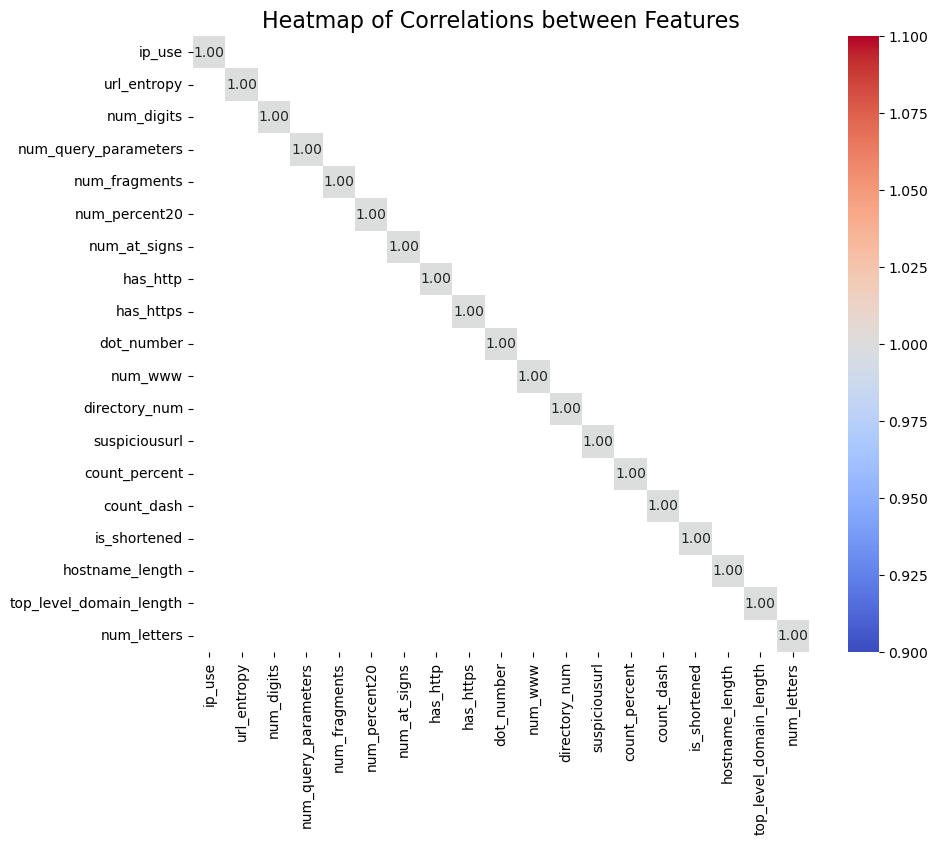

In [23]:
# showing features heatmap

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

correlation_matrix = df.drop(columns=['type', 'url']).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True, mask = (np.abs(correlation_matrix) <= 0.9))
plt.title("Heatmap of Correlations between Features", fontsize=16)
plt.show()

In [7]:
# we will remove, given the heatmap, the features with a correlation >= 0.9. List:
# embed_domain_number, count_equal, url_length, first_directory_length
df = df.drop(columns=["embed_domain_number", "count_equal", "url_length", "first_directory_length"])

print(f"Total no. of features after removal: { df.drop(columns=['type', 'url']).shape[1] }")

Total no. of features after removal: 19


In [8]:
# we divide the dataset into training set (80%) and test set (20%)
from sklearn.model_selection import train_test_split
from utils.utils import printInfo

train_ratio = 0.80
test_ratio = 0.20
x_train_unbalanced, x_test, y_train_unbalanced, y_test = train_test_split(df.drop(columns=["type", "url"]).copy(), df["type"].copy(), test_size=1-train_ratio, shuffle=True, stratify=df["type"].copy())

printInfo("training with outliers", y_train_unbalanced)

training with outliers samples [tot: 512895]:
 phishing class: 75274 (14.68% of total)
 benign class: 342459 (66.77% of total)
 defacement class: 76246 (14.87% of total)
 malware class: 18916 (3.69% of total)


In [9]:
# We remove outliers from the training set.
# We decided to set a fairly conservative threshold (3x IQR) given the nature of the numerous outliers, which do not arise from measurement errors, 
# but represent possible malicious URLs or edge cases. Removing them too aggressively (1.5xIQR) would risk losing relevant examples for the model. 
# The larger threshold maximizes the retention of potentially informative data while reducing excessive extreme values.
from utils.utils import remove_outliers

x_train_clean_unbalanced = remove_outliers(x_train_unbalanced)
y_train_clean_unbalanced = y_train_unbalanced[x_train_clean_unbalanced.index]

printInfo("training without outliers", y_train_clean_unbalanced)
print(f"Reduction of the training dataset by {x_train_unbalanced.shape[0] - x_train_clean_unbalanced.shape[0]} elements ({((x_train_unbalanced.shape[0] - x_train_clean_unbalanced.shape[0]) / x_train_unbalanced.shape[0]) * 100:.2f}% reduction)")

printInfo("test", y_test)

training without outliers samples [tot: 487443]:
 phishing class: 71603 (14.69% of total)
 benign class: 326996 (67.08% of total)
 defacement class: 72994 (14.97% of total)
 malware class: 15850 (3.25% of total)
Reduction of the training dataset by 25452 elements (4.96% reduction)
test samples [tot: 128224]:
 benign class: 85615 (66.77% of total)
 defacement class: 19062 (14.87% of total)
 malware class: 4729 (3.69% of total)
 phishing class: 18818 (14.68% of total)


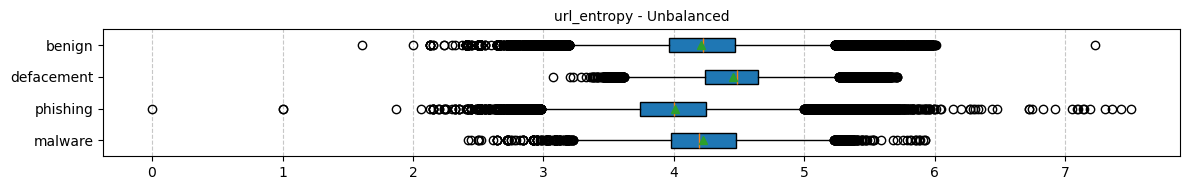

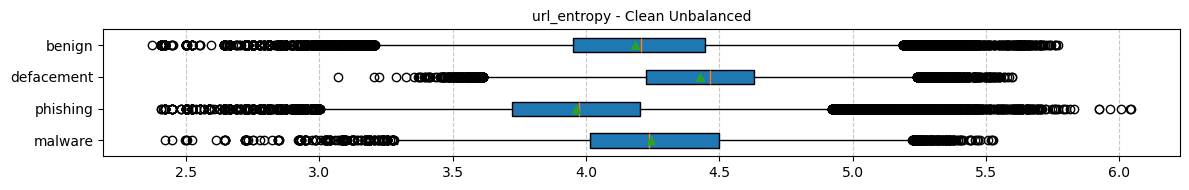

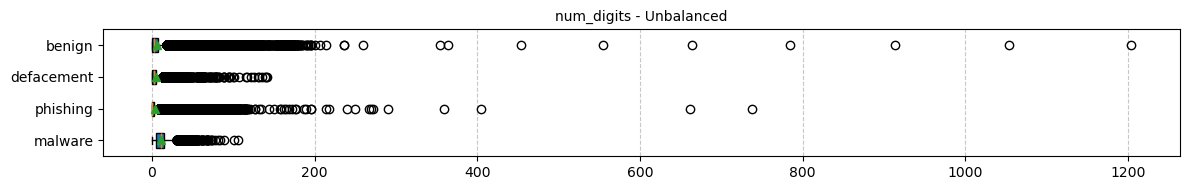

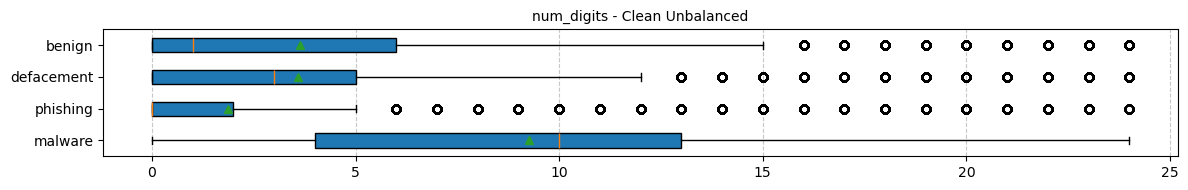

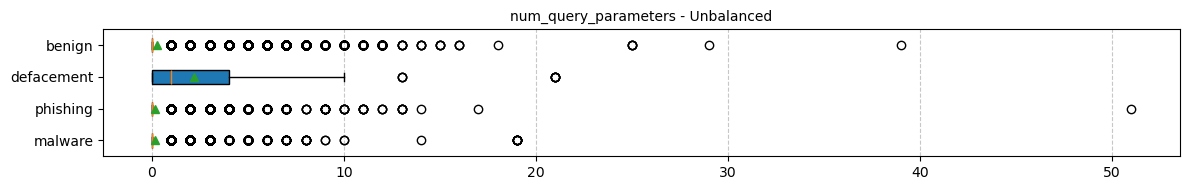

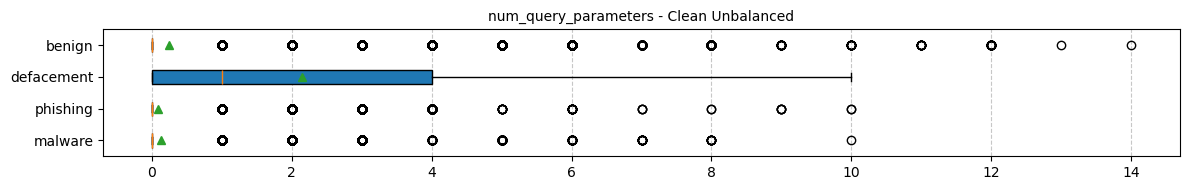

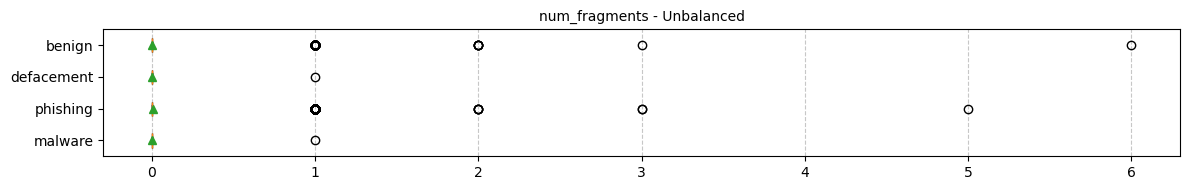

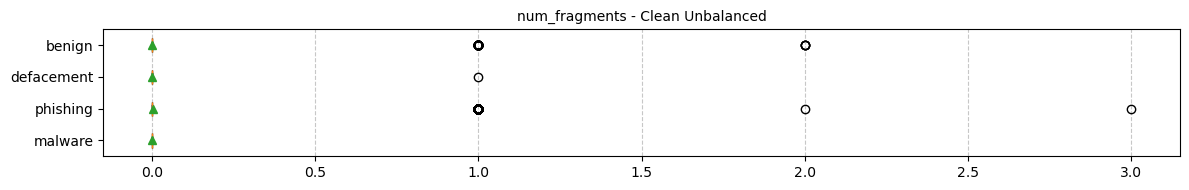

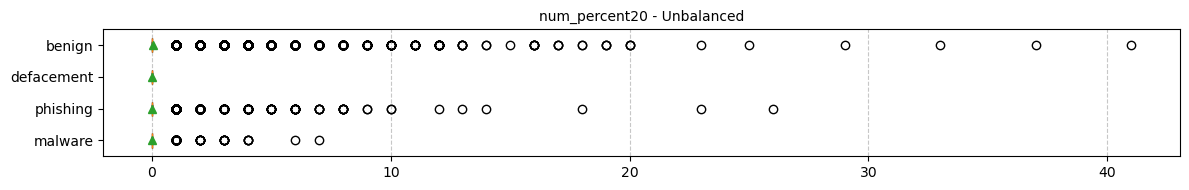

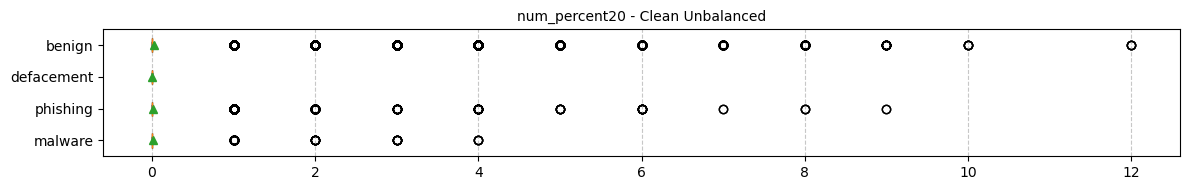

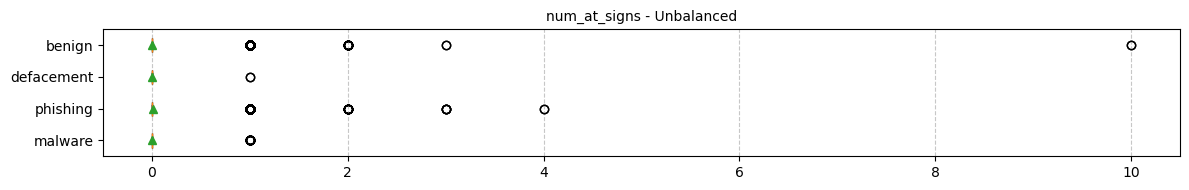

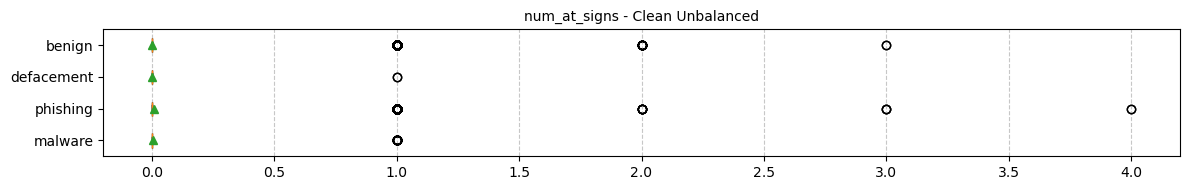

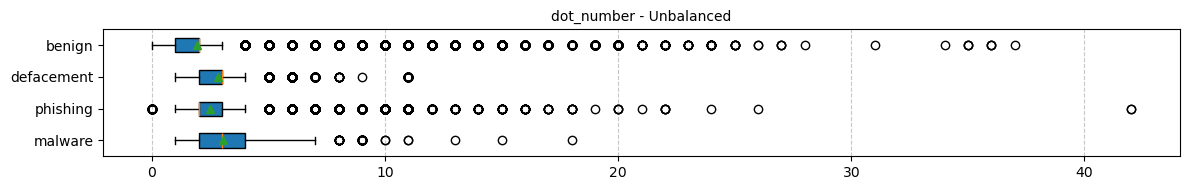

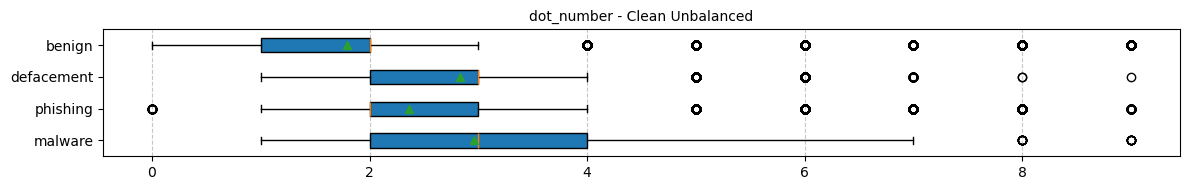

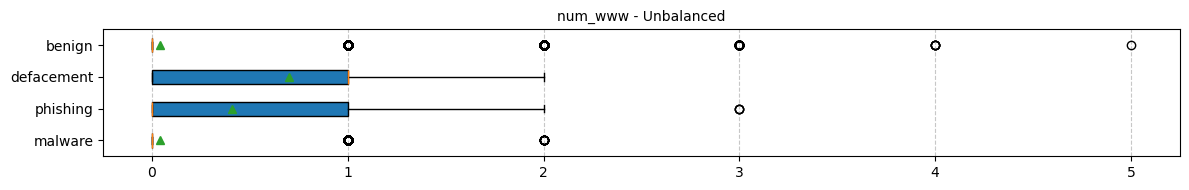

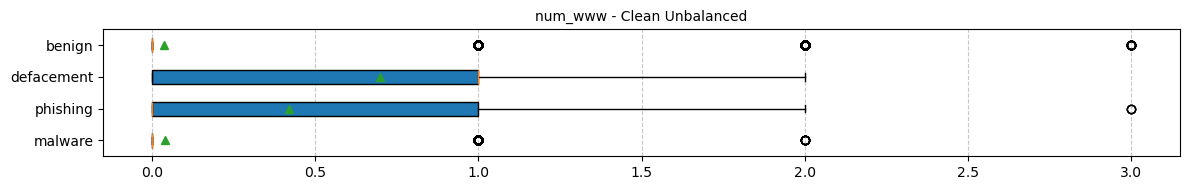

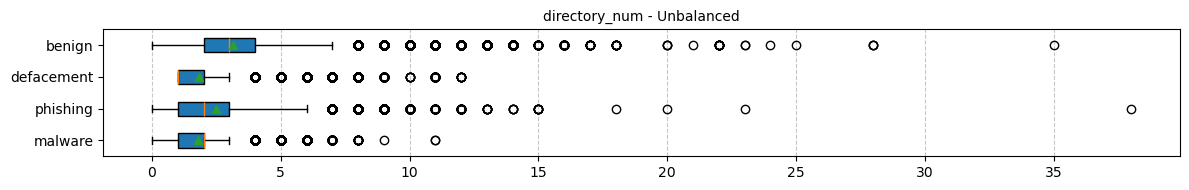

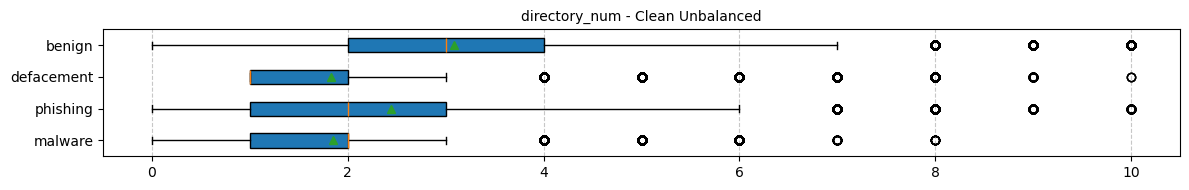

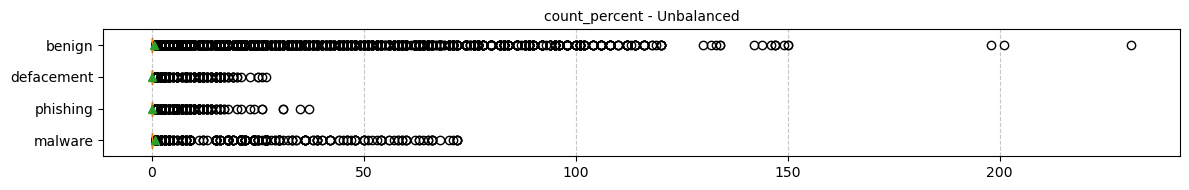

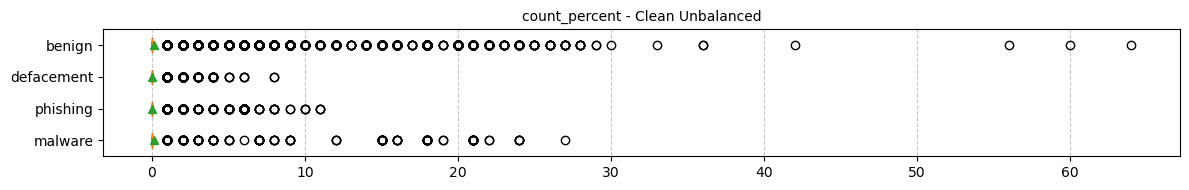

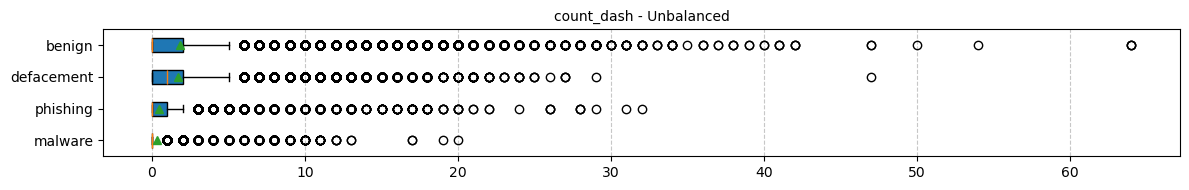

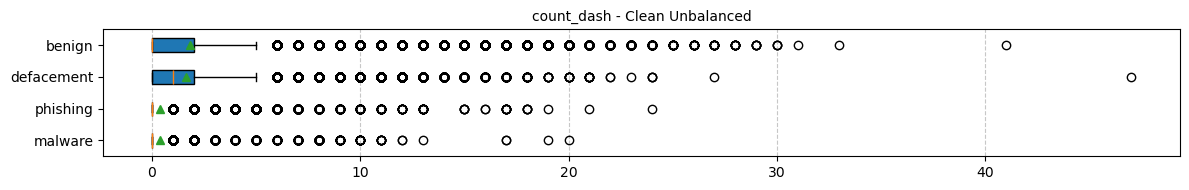

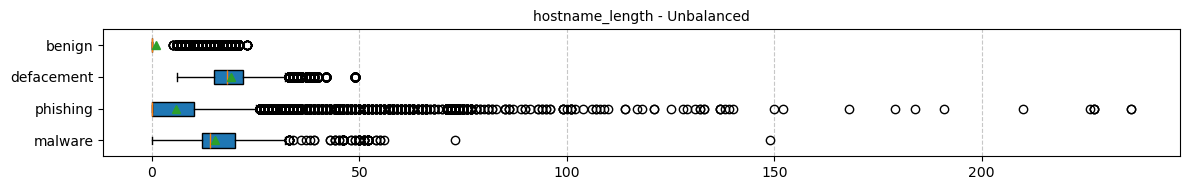

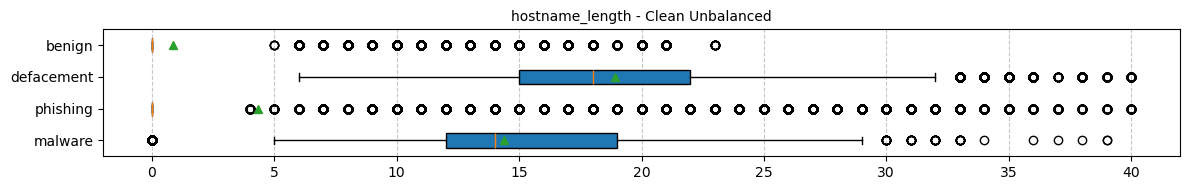

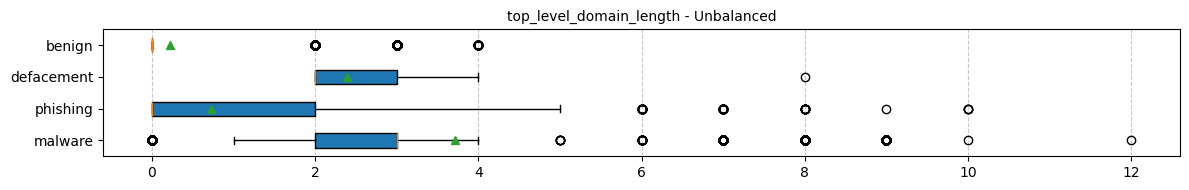

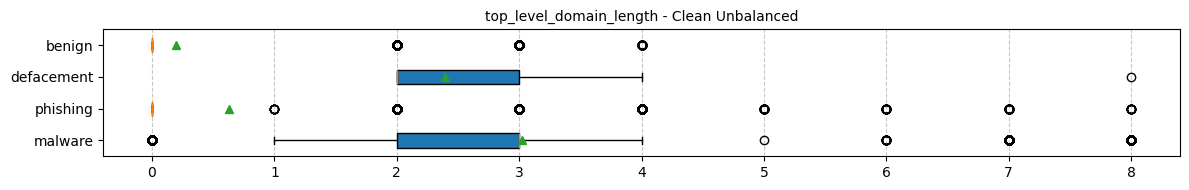

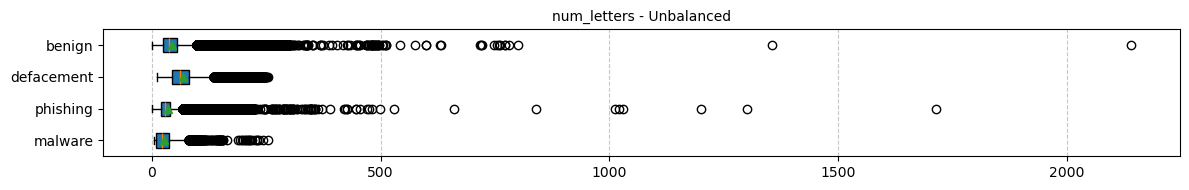

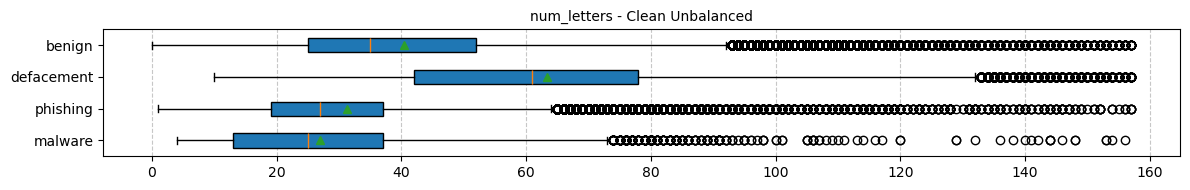

In [10]:
# We create two box plots for each of these features. The first is for the dataset with outliers, the second without them.
import matplotlib.pyplot as plt

features = ['url_entropy', 'num_digits', 'num_query_parameters', 'num_fragments', 'num_percent20', 'num_at_signs', 'dot_number', 'num_www', 'directory_num', 'count_percent', 'count_dash', 'hostname_length', 'top_level_domain_length', 'num_letters']
classes = df["type"].unique()

for feature in features:
    plt.figure(figsize=(12, 2))
    
    # First boxplot with x_train_unbalanced and y_train_unbalanced
    data = [x_train_unbalanced[y_train_unbalanced == class_label][feature].dropna() for class_label in classes]
    plt.boxplot(data, vert=False, patch_artist=True, showmeans=True, labels=classes)
    plt.title(f'{feature} - Unbalanced', fontsize=10)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Second boxplot with x_train_clean_unbalanced and y_train_clean_unbalanced
    plt.figure(figsize=(12, 2))
    data_clean = [x_train_clean_unbalanced[y_train_clean_unbalanced == class_label][feature].dropna() for class_label in classes]
    plt.boxplot(data_clean, vert=False, patch_artist=True, showmeans=True, labels=classes)
    plt.title(f'{feature} - Clean Unbalanced', fontsize=10)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [11]:
# one aspect that we notice from the above output is the imbalance, in terms of number of samples, of the malicious class compared to the benign one.
from utils.utils import balance_data_undersample_benign

x_train, y_train = balance_data_undersample_benign(x_train_unbalanced, y_train_unbalanced)
x_train_clean, y_train_clean = balance_data_undersample_benign(x_train_clean_unbalanced, y_train_clean_unbalanced) # senza outliers
printInfo("training balanced", y_train)
print()
printInfo("training cleaned balanced", y_train_clean)

training balanced samples [tot: 340872]:
 benign class: 170436 (50.00% of total)
 defacement class: 76246 (22.37% of total)
 malware class: 18916 (5.55% of total)
 phishing class: 75274 (22.08% of total)

training cleaned balanced samples [tot: 320894]:
 benign class: 160447 (50.00% of total)
 defacement class: 72994 (22.75% of total)
 malware class: 15850 (4.94% of total)
 phishing class: 71603 (22.31% of total)


## Random Forest

Stratified K-Fold Cross Validation Results:
Mean Accuracy: 0.9496 ± 0.0006
Mean F1 Score: 0.9488 ± 0.0007
Mean AUC Score: 0.9828 ± 0.0002

Classification Report:
              precision    recall  f1-score   support

      benign       0.96      0.98      0.97     85615
    phishing       0.97      0.99      0.98     19062
  defacement       0.98      0.90      0.94      4729
     malware       0.86      0.80      0.83     18818

    accuracy                           0.95    128224
   macro avg       0.94      0.92      0.93    128224
weighted avg       0.95      0.95      0.95    128224


AUC Score: 0.9828


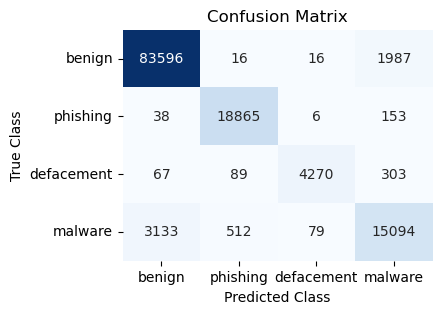

In [12]:
# unbalanced, with outliers
from sklearn.ensemble import RandomForestClassifier
from utils.utils import evaluate_model_with_cv

evaluate_model_with_cv(x_train_unbalanced, y_train_unbalanced, RandomForestClassifier(), x_test, y_test)

Stratified K-Fold Cross Validation Results:
Mean Accuracy: 0.9475 ± 0.0008
Mean F1 Score: 0.9466 ± 0.0008
Mean AUC Score: 0.9808 ± 0.0005

Classification Report:
              precision    recall  f1-score   support

      benign       0.96      0.98      0.97     85615
    phishing       0.96      0.99      0.97     19062
  defacement       0.98      0.89      0.93      4729
     malware       0.85      0.80      0.82     18818

    accuracy                           0.95    128224
   macro avg       0.94      0.91      0.92    128224
weighted avg       0.95      0.95      0.95    128224


AUC Score: 0.9819


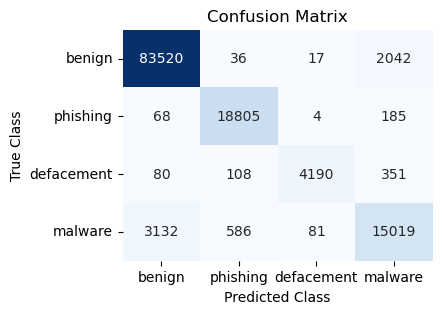

In [13]:
# unbalanced, w/o outliers
from sklearn.ensemble import RandomForestClassifier
from utils.utils import evaluate_model_with_cv

evaluate_model_with_cv(x_train_clean_unbalanced, y_train_clean_unbalanced, RandomForestClassifier(), x_test, y_test)

Stratified K-Fold Cross Validation Results:
Mean Accuracy: 0.9342 ± 0.0009
Mean F1 Score: 0.9336 ± 0.0009
Mean AUC Score: 0.9837 ± 0.0002

Classification Report:
              precision    recall  f1-score   support

      benign       0.97      0.96      0.96     85615
    phishing       0.97      0.99      0.98     19062
  defacement       0.97      0.90      0.94      4729
     malware       0.80      0.84      0.82     18818

    accuracy                           0.94    128224
   macro avg       0.93      0.92      0.92    128224
weighted avg       0.94      0.94      0.94    128224


AUC Score: 0.9837


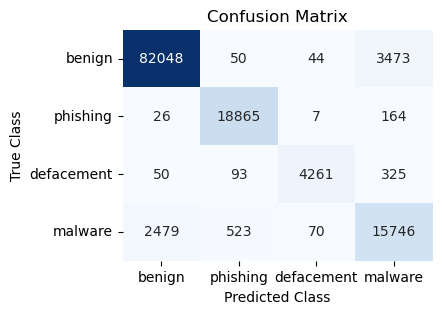

In [14]:
# balanced, with outliers
from sklearn.ensemble import RandomForestClassifier
from utils.utils import evaluate_model_with_cv

evaluate_model_with_cv(x_train, y_train, RandomForestClassifier(), x_test, y_test)

Stratified K-Fold Cross Validation Results:
Mean Accuracy: 0.9308 ± 0.0013
Mean F1 Score: 0.9302 ± 0.0013
Mean AUC Score: 0.9824 ± 0.0006

Classification Report:
              precision    recall  f1-score   support

      benign       0.97      0.95      0.96     85615
    phishing       0.96      0.99      0.97     19062
  defacement       0.97      0.89      0.93      4729
     malware       0.79      0.83      0.81     18818

    accuracy                           0.94    128224
   macro avg       0.92      0.92      0.92    128224
weighted avg       0.94      0.94      0.94    128224


AUC Score: 0.9827


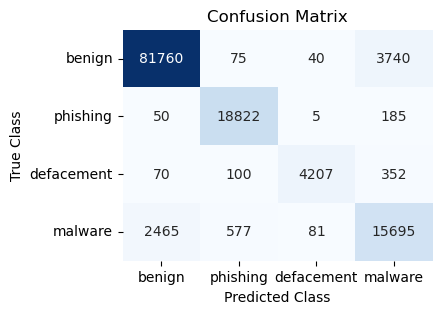

In [15]:
# balanced, w/o outliers
from sklearn.ensemble import RandomForestClassifier
from utils.utils import evaluate_model_with_cv

evaluate_model_with_cv(x_train_clean, y_train_clean, RandomForestClassifier(), x_test, y_test)

## Logistic Regression

In [16]:
# we perform a data normalization, necessary for logistic regression
from sklearn.preprocessing import StandardScaler

COLUMNS_TO_IGNORE = ['ip_use', 'has_http', 'has_https', 'suspiciousurl'] # binary features

# defining features to normalize (all except those to ignore)
non_binary_columns = [col for col in x_train.columns if col not in COLUMNS_TO_IGNORE]

# scaling with StandardScaler
scaler = StandardScaler()

# training set with outliers
x_train_unbalanced_scaled = x_train_unbalanced.copy()
x_train_unbalanced_scaled[non_binary_columns] = scaler.fit_transform(x_train_unbalanced[non_binary_columns])

# training set w/o outliers
x_train_clean_unbalanced_scaled = x_train_clean_unbalanced.copy()
x_train_clean_unbalanced_scaled[non_binary_columns] = scaler.fit_transform(x_train_clean_unbalanced_scaled[non_binary_columns])

# test set (NOT MODIFIED)
x_test_scaled = x_test.copy()
x_test_scaled[non_binary_columns] = scaler.transform(x_test[non_binary_columns])

In [17]:
# binary regression cannot accept values ​​other than 0 and 1, so we change the classes to only two.
from utils.utils import balance_data_undersample_benign, merge_classes_to_binary

x_binary_train_scaled, y_binary_train = balance_data_undersample_benign(x_train_unbalanced_scaled, merge_classes_to_binary(y_train_unbalanced))
x_binary_train_clean_scaled, y_binary_train_clean = balance_data_undersample_benign(x_train_clean_unbalanced_scaled, merge_classes_to_binary(y_train_clean_unbalanced))

y_binary_test = merge_classes_to_binary(y_test)

printInfo("training binary balanced", y_binary_train)
print()
printInfo("training binary cleaned balanced", y_binary_train_clean)

training binary balanced samples [tot: 340872]:
 benign class: 170436 (50.00% of total)
 malignant class: 170436 (50.00% of total)

training binary cleaned balanced samples [tot: 320894]:
 benign class: 160447 (50.00% of total)
 malignant class: 160447 (50.00% of total)


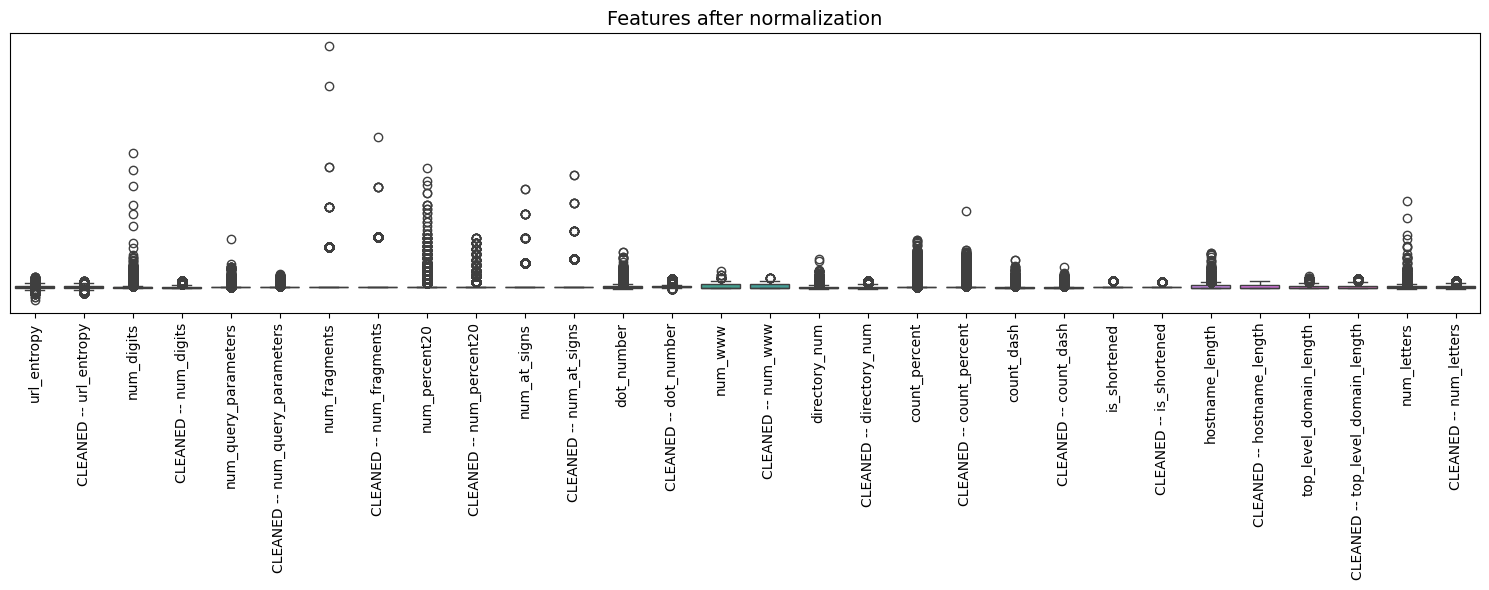

In [18]:
# showing the distribution of features with and without outliers (it takes about 30 seconds)
import matplotlib.pyplot as plt
import seaborn as sns

combined_data = pd.DataFrame()
for column in non_binary_columns:
    combined_data[column] = x_binary_train_scaled[column]
    combined_data["CLEANED -- " + column] = x_binary_train_clean_scaled[column]

columns_for_plot = []
for column in non_binary_columns:
    columns_for_plot.append(column)
    columns_for_plot.append("CLEANED -- " + column)

# Creazione del boxplot
plt.figure(figsize=(len(columns_for_plot) * 0.5, 6))
sns.boxplot(data=combined_data[columns_for_plot])
plt.title('Features after normalization', fontsize=14)
plt.xticks(rotation=90)
plt.gca().axes.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()

Stratified K-Fold Cross Validation Results:
Mean Accuracy: 0.9012 ± 0.0006
Mean F1 Score: 0.8992 ± 0.0006
Mean AUC Score: 0.9452 ± 0.0003

Classification Report:
              precision    recall  f1-score   support

      benign       0.90      0.96      0.93     85615
   malignant       0.91      0.78      0.84     42609

    accuracy                           0.90    128224
   macro avg       0.90      0.87      0.89    128224
weighted avg       0.90      0.90      0.90    128224


AUC Score: 0.9435


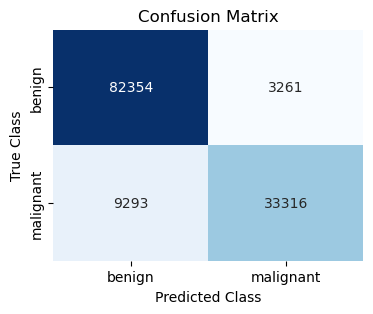

In [19]:
# unbalanced and normalized, with outliers
from sklearn.linear_model import LogisticRegression
from utils.utils import evaluate_model_with_cv

evaluate_model_with_cv(x_train_unbalanced_scaled, merge_classes_to_binary(y_train_unbalanced), LogisticRegression(), x_test_scaled, y_binary_test, ['benign', 'malignant'])

Stratified K-Fold Cross Validation Results:
Mean Accuracy: 0.9037 ± 0.0007
Mean F1 Score: 0.9015 ± 0.0007
Mean AUC Score: 0.9480 ± 0.0004

Classification Report:
              precision    recall  f1-score   support

      benign       0.90      0.96      0.93     85615
   malignant       0.91      0.78      0.84     42609

    accuracy                           0.90    128224
   macro avg       0.90      0.87      0.88    128224
weighted avg       0.90      0.90      0.90    128224


AUC Score: 0.9420


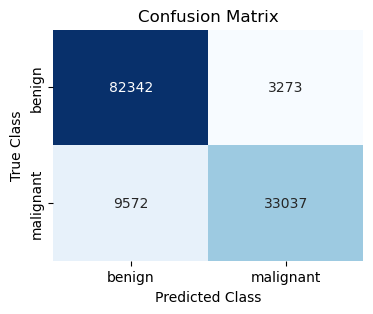

In [20]:
# unbalanced and normalized, without outliers
from sklearn.linear_model import LogisticRegression
from utils.utils import evaluate_model_with_cv

evaluate_model_with_cv(x_train_clean_unbalanced_scaled, merge_classes_to_binary(y_train_clean_unbalanced), LogisticRegression(), x_test_scaled, y_binary_test, ['benign', 'malignant'])

Stratified K-Fold Cross Validation Results:
Mean Accuracy: 0.8754 ± 0.0014
Mean F1 Score: 0.8752 ± 0.0014
Mean AUC Score: 0.9461 ± 0.0006

Classification Report:
              precision    recall  f1-score   support

      benign       0.92      0.92      0.92     85615
   malignant       0.83      0.84      0.83     42609

    accuracy                           0.89    128224
   macro avg       0.87      0.88      0.88    128224
weighted avg       0.89      0.89      0.89    128224


AUC Score: 0.9448


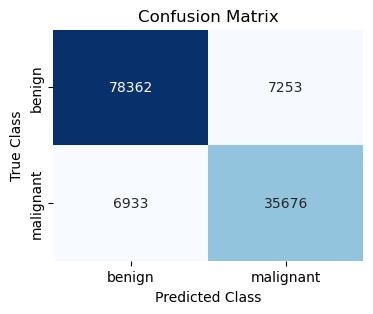

In [21]:
# balanced and normalized, with outliers
from sklearn.linear_model import LogisticRegression
from utils.utils import evaluate_model_with_cv

evaluate_model_with_cv(x_binary_train_scaled, y_binary_train, LogisticRegression(), x_test_scaled, y_binary_test, ['benign', 'malignant'])

Stratified K-Fold Cross Validation Results:
Mean Accuracy: 0.8768 ± 0.0005
Mean F1 Score: 0.8766 ± 0.0005
Mean AUC Score: 0.9492 ± 0.0003

Classification Report:
              precision    recall  f1-score   support

      benign       0.92      0.92      0.92     85615
   malignant       0.83      0.83      0.83     42609

    accuracy                           0.89    128224
   macro avg       0.87      0.87      0.87    128224
weighted avg       0.89      0.89      0.89    128224


AUC Score: 0.9438


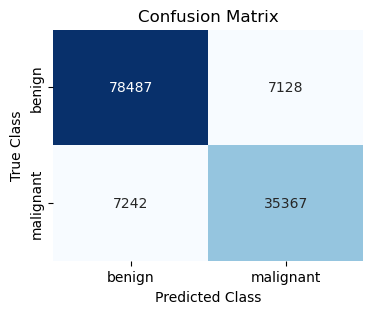

In [22]:
# balanced and normalized, without outliers
from sklearn.linear_model import LogisticRegression

evaluate_model_with_cv(x_binary_train_clean_scaled, y_binary_train_clean, LogisticRegression(), x_test_scaled, y_binary_test, ['benign', 'malignant'])

## PCA

TODO